# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [4]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


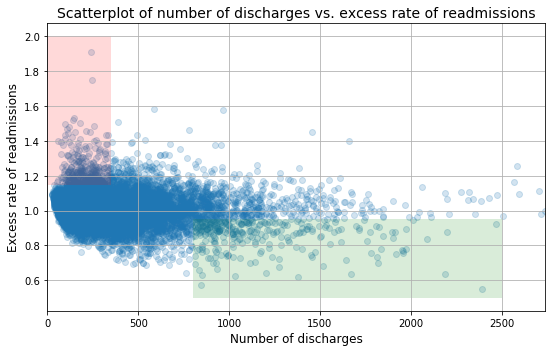

In [5]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [6]:
# Your turn

A. 

There certianly does appear to be a spike in excess rate of remissions for smaller hospitals, so I would agree that it's likely that smaller hospitals tend to have a higher rate of remissions. However, this analysis didn't include any statistical testing to determine whether the observed correlation is statistically significant, and thus their conclusions seemed a bit hasty. I would want to perform some kind of hypothesis testing before advising the hospitals. 


B. 

To do a more rigerous analysis, we should set up a hypothesis test. To test their hypothesis, that smaller hospitals have a higher excess rate of remissions, we should examine whether the mean excess rate of remissions of the small hospitals is statistically significantly higher than the mean excess rate of remissions for larger hospitals. We're going to divide the data into two groups, take their means, find the difference, and do a two-sample bootstrap hypothesis test for difference of means. I'm going to use bootstrapping, but a frequentist approach would work just as well. 


In [7]:
# Group the hospitals into small and large by number of discharges

small_h = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] <= 300]
large_h = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] > 300]


In [8]:
# First, we'll define a function that takes the difference of two means, for later use in our analysis:

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [9]:
# Next, we'll create some functions for boostrapping:

# Generates a single sample
def bootstrap_replicate_1d(data, func):
     """Generate bootstrap replicate of 1D data."""
     bs_sample = np.random.choice(data, len(data))
     return func(bs_sample)

# Generates many replicate samples
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [10]:
# Compute the difference in mean Excess Readmission Ratio
diff_means = diff_of_means(small_h['Excess Readmission Ratio'], large_h['Excess Readmission Ratio'])

# Compute mean of pooled data, aka the mean of all the data
mean_count = np.mean(np.concatenate((small_h['Excess Readmission Ratio'], large_h['Excess Readmission Ratio'])))

# Generate shifted data sets, so the means are the same (if they really and the null hypothesis is true, 
# this shouldn't make a difference, which is what we're testing)
small_shifted = small_h['Excess Readmission Ratio'] - np.mean(small_h['Excess Readmission Ratio']) + mean_count
large_shifted = large_h['Excess Readmission Ratio'] - np.mean(large_h['Excess Readmission Ratio']) + mean_count

# Generate bootstrap replicates for the large and small hospitals seperately 
bs_reps_small = draw_bs_reps(small_shifted,
                       np.mean, size=10000)
bs_reps_large = draw_bs_reps(large_shifted,
                       np.mean, size=10000)

# Get replicates of difference of means for each replicate 
bs_replicates = bs_reps_small - bs_reps_large

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(small_h['Excess Readmission Ratio']) - np.mean(large_h['Excess Readmission Ratio'])) \
            / len(bs_replicates)

print('p-value =', p)

p-value = 0.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


The p value here is 0, which indicates a statistically significant difference at the a = 0.01 level. However, we should also look at the practical significance here. Let's see what that difference really is.

In [11]:
diff_means

0.014479507404359437

Another way to measure the practical significance of a finding is to measure its effect size. For this we usually calculate Cohen's D, a determinant of effect size. The function created to calculate Cohen's D is below:

In [12]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [13]:
# Next, we calculate Cohen's D for our data:

print ("d = " + str(cohen_d(small_h['Excess Readmission Ratio'], large_h['Excess Readmission Ratio'])))

d = 0.1580343086729674


Cohen's D here is about 0.16, which is a very small effect size. A small effect size is usually 0.2, medium is 0.5 and large is 0.8. Here we see an effect that is even smaller than the smallest cutoff. This further implies that the practical implications of this, although statistically significant, effect are limited. This would lead me to change my reccomendation to the client, and say that the hospital size may not have a large practical effect on the Excess Readmission Ratio for the hospitals. 

The plot above is a little misleading, as there are so many hospitals concentrated in the bulk of the data that it is hard to see whether those outside the more populated areas are a large portion of the data or simply outliers. A 2-D Histogram, which can display the concentration of the data if used with a colorbar, is one solution. Another more telling solution would be to use a joinplot with a hexabin specification. This both indicates the concentration of the data points (using color) and shows the distribution of both variables. It also displays the r value, which cab be useful if you're trying to determine the relationship between two variables. Both visualizations are displayed below. 

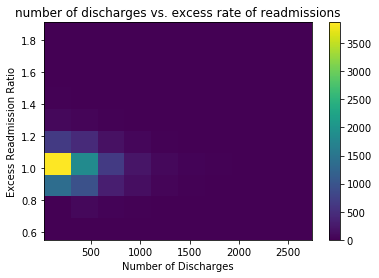

In [14]:
# Generate a 2-D histogram 

plt.hist2d(x, y)

# Add a color bar to the histogram
plt.colorbar()

# Add labels, title, and display the plot
plt.xlabel('Number of Discharges')
plt.ylabel('Excess Readmission Ratio')
plt.title('number of discharges vs. excess rate of readmissions')
plt.show()

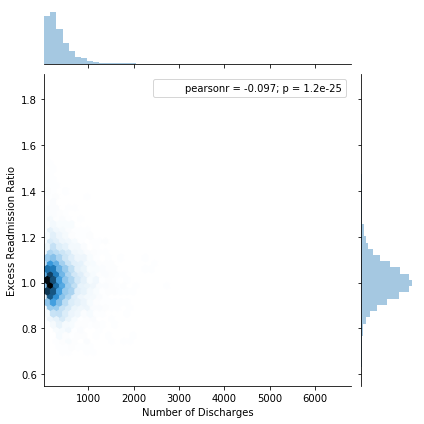

In [17]:
# Generate a joint plot of 'hp' and 'mpg'
sns.jointplot(x='Number of Discharges', y='Excess Readmission Ratio', data=clean_hospital_read_df, kind='hex')

# Display the plot
plt.show()

As we can see from these visualizations, there are a number of datapoints around Excess Readmission Ratio = 1 and that contain a low number of discharges. In fact most of the data is concentrated here. This shows us why there is not a strong correlation or practical significance to our result. The data we thought was important on the scatterplot earlier appear to have been outliers, and mislead the original hypothesis. This visual communicates how clustered the data is over that one point, and shows us that not every statistically significant result has practical meaning.